In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
from src.data.data import get_engineered_dataloaders, get_simplified_dataloaders, get_festive_dataloaders
from run.scripts import train_test, check_memory
from torch.nn import MSELoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from torch.optim import Adam
import torch

from src.ml.model import EpochPlayerModel, MckinneyPlayerModel
torch.manual_seed(2002);

In [57]:
train_dataloader, val_dataloader, test_dataloader = get_festive_dataloaders(name='elephant', train_split=0.8, val_split=0.1, test_split=0.1, batch_size=32)

/Users/sharshe/Documents/TBN/src/data/data.py:416: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  try:


In [58]:
x, y = next(iter(train_dataloader))

torch.Size([25])
torch.Size([3])
torch.Size([24])
torch.Size([4])
torch.Size([20])
torch.Size([8])
torch.Size([28])
torch.Size([0])
torch.Size([24])
torch.Size([4])
torch.Size([26])
torch.Size([2])
torch.Size([24])
torch.Size([4])
torch.Size([26])
torch.Size([2])
torch.Size([24])
torch.Size([4])
torch.Size([24])
torch.Size([4])
torch.Size([26])
torch.Size([2])
torch.Size([26])
torch.Size([2])
torch.Size([24])
torch.Size([4])
torch.Size([24])
torch.Size([4])
torch.Size([27])
torch.Size([1])
torch.Size([22])
torch.Size([6])
torch.Size([24])
torch.Size([4])
torch.Size([23])
torch.Size([5])
torch.Size([24])
torch.Size([4])
torch.Size([22])
torch.Size([6])
torch.Size([24])
torch.Size([4])
torch.Size([24])
torch.Size([4])
torch.Size([26])
torch.Size([2])
torch.Size([24])
torch.Size([4])
torch.Size([24])
torch.Size([4])
torch.Size([22])
torch.Size([6])
torch.Size([22])
torch.Size([6])
torch.Size([22])
torch.Size([6])
torch.Size([25])
torch.Size([3])
torch.Size([23])
torch.Size([5])
torch.Size

In [44]:
cfg_dict = {
    'name': 'george',
    'dataset_name': 'elephant',
    'x_version': 'players',
    'y_version': 'score',
    'batch_size': 16,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'n_epochs': 100,
    'loss_fn': 'MSELoss',
    'optimizer': 'Adam',
    'scheduler': 'ReduceLROnPlateau',
    'model': 'EpochPlayerModel',
    'd_mod': 32
}

In [45]:
model = MckinneyPlayerModel(d_in=10, d_out=2, d_mod=cfg_dict['d_mod'])

final prediction: model(x)
[[0.5599997639656067, 0.571022629737854], [0.5599998235702515, 0.571022629737854]]
actual value: y
[[0.508571445941925, 0.5738636255264282], [0.6114285588264465, 0.5681818127632141]]
final loss: 0.0013


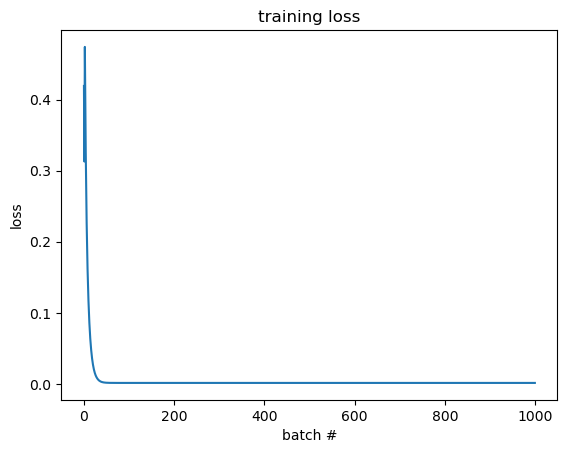

In [39]:
check_memory(model=model, dataloader=train_dataloader, n_epochs=1000, batch_size=2, lr=3e-4)

In [46]:
optimizer = Adam(model.parameters(), lr=3e-4)
loss_fn = MSELoss()
# scheduler = OneCycleLR(
#     optimizer,
#     max_lr=1e-3,
#     epochs=cfg_dict['n_epochs'],
#     steps_per_epoch=len(train_dataloader),
#     pct_start=0.3,
#     div_factor=25,
#     final_div_factor=10000,
# )
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=4)
n_epochs = cfg_dict['n_epochs']

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


EPOCH 1 OF 100 | george | TRAIN MEAN LOSS: 0.008117 | VAL MEAN LOSS: 0.006275
EPOCH 2 OF 100 | george | TRAIN MEAN LOSS: 0.006387 | VAL MEAN LOSS: 0.006062
EPOCH 3 OF 100 | george | TRAIN MEAN LOSS: 0.006372 | VAL MEAN LOSS: 0.006364
EPOCH 4 OF 100 | george | TRAIN MEAN LOSS: 0.006396 | VAL MEAN LOSS: 0.006440
EPOCH 5 OF 100 | george | TRAIN MEAN LOSS: 0.006337 | VAL MEAN LOSS: 0.006780
EPOCH 6 OF 100 | george | TRAIN MEAN LOSS: 0.006353 | VAL MEAN LOSS: 0.006028
EPOCH 7 OF 100 | george | TRAIN MEAN LOSS: 0.006315 | VAL MEAN LOSS: 0.006024
EPOCH 8 OF 100 | george | TRAIN MEAN LOSS: 0.006311 | VAL MEAN LOSS: 0.006488
EPOCH 9 OF 100 | george | TRAIN MEAN LOSS: 0.006116 | VAL MEAN LOSS: 0.006153
EPOCH 10 OF 100 | george | TRAIN MEAN LOSS: 0.005957 | VAL MEAN LOSS: 0.006363
EPOCH 11 OF 100 | george | TRAIN MEAN LOSS: 0.005870 | VAL MEAN LOSS: 0.005712
EPOCH 12 OF 100 | george | TRAIN MEAN LOSS: 0.005904 | VAL MEAN LOSS: 0.005923
EPOCH 13 OF 100 | george | TRAIN MEAN LOSS: 0.005876 | VAL ME

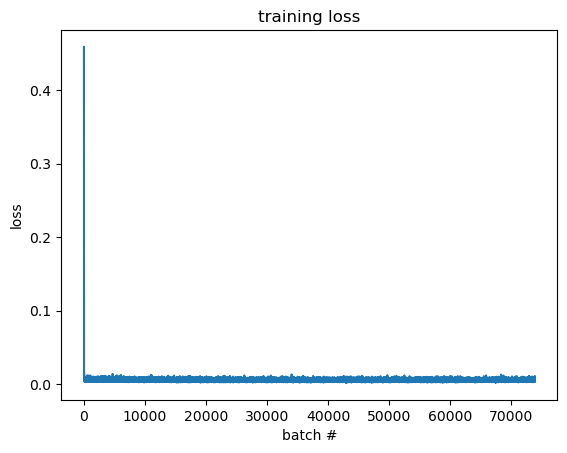

TEST MEAN LOSS: 0.005665
TEST ACCURACY: 0.590386


learning_rate,████▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_mean_loss,▁
train_mean_loss,█▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_loss,▅▄█▄▆▂▃▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
test_accuracy,0.59039
test_mean_loss,0.00567
train_mean_loss,0.00562
val_mean_loss,0.00557


In [47]:
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=train_dataloader, val_dataloader=val_dataloader, test_dataloader=test_dataloader, cfg_dict=cfg_dict)

In [ ]:
cfg_dict.update({
    'train_split': 0.08,
    'val_split': 0.01,
    'test_split': 0.01
})
train_test(model=model, optimizer=optimizer, scheduler=scheduler, loss_fn=loss_fn, train_dataloader=mini_train_score_dataloader, val_dataloader=mini_val_score_dataloader, test_dataloader=mini_test_score_dataloader, cfg_dict=cfg_dict)
cfg_dict.update({
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1
})